# 3. Convolutional LSTM

## 데이터 수집

In [21]:
from pandas_datareader import data as pdr
import yfinance as yfin
from datetime import date, datetime

today = date.today()
date_today = today.strftime("%Y-%m-%d")
date_start = datetime(2013,1,1)

# BTC(KRW)
yfin.pdr_override()

btc_krwname = 'Bitcoin(KRW)'
btc_krw = 'BTC-KRW'
btc_krw_df = pdr.get_data_yahoo(btc_krw, start=date_start, end=date_today)

print(btc_krw_df.shape)
btc_krw_df

[*********************100%***********************]  1 of 1 completed
(3177, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,4.826118e+05,4.838110e+05,4.681210e+05,4.732035e+05,4.732035e+05,21787470960
2014-09-18,4.727130e+05,4.762765e+05,4.309914e+05,4.428182e+05,4.428182e+05,35976322560
2014-09-19,4.424667e+05,4.475154e+05,4.012784e+05,4.119893e+05,4.119893e+05,39571102935
2014-09-20,4.118610e+05,4.417305e+05,4.068624e+05,4.267118e+05,4.267118e+05,38469009780
2014-09-21,4.258571e+05,4.303872e+05,4.103040e+05,4.161897e+05,4.161897e+05,27737663355
...,...,...,...,...,...,...
2023-05-25,3.594165e+07,3.594165e+07,3.446848e+07,3.473084e+07,3.473084e+07,21495559019063
2023-05-26,3.472378e+07,3.536380e+07,3.423304e+07,3.524552e+07,3.524552e+07,18438822300836
2023-05-27,3.524283e+07,3.568314e+07,3.491508e+07,3.536111e+07,3.536111e+07,16822938231443


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# 데이터 분할
train_size = int(len(btc_krw_df) * 0.8)
train_data = btc_krw_df[:train_size]
test_data = btc_krw_df[train_size:]

# 분위수 정규화 수행
normalized_train_data = rankdata(train_data['Adj Close']) / len(train_data)
normalized_test_data = rankdata(test_data['Adj Close']) / len(test_data)

# 추세 제거를 위한 이동평균 계산
window = 60 # 이동평균 윈도우 크기
rolling_mean_train = pd.Series(normalized_train_data).rolling(window=window, min_periods=1).mean()
rolling_mean_test = pd.Series(normalized_test_data).rolling(window=window, min_periods=1).mean()

# 추세 제거
detrended_train_data = normalized_train_data - rolling_mean_train
detrended_test_data = normalized_test_data - rolling_mean_test

# 시계열 데이터 추출
sequence_length = 7 # 입력 시퀀스 길이
X_train = []
y_train = []
for i in range(len(detrended_train_data) - sequence_length):
    X_train.append(detrended_train_data[i:i + sequence_length])
    y_train.append(detrended_train_data[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = []
y_test = []
for i in range(len(detrended_test_data) - sequence_length):
    X_test.append(detrended_test_data[i:i + sequence_length])
    y_test.append(detrended_test_data[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Convolutional LSTM 모델 구축
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=4, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='tanh'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Early Stopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train[..., np.newaxis], y_train, epochs=100, batch_size=32, verbose=1,
validation_data=(X_test[..., np.newaxis], y_test), callbacks=[early_stopping])

# 학습 데이터 예측
train_predictions = model.predict(X_train[..., np.newaxis])
train_predictions = train_predictions.flatten()

# 테스트 데이터 예측
test_predictions = model.predict(X_test[..., np.newaxis])
test_predictions = test_predictions.flatten()

Epoch 1/100
80/80 [==============================] - 3s 10ms/step - loss: 0.0026 - val_loss: 0.0128
Epoch 2/100
80/80 [==============================] - 0s 6ms/step - loss: 0.0012 - val_loss: 0.0061
Epoch 3/100
80/80 [==============================] - 0s 4ms/step - loss: 6.2214e-04 - val_loss: 0.0050
Epoch 4/100
80/80 [==============================] - 0s 5ms/step - loss: 5.4867e-04 - val_loss: 0.0043
Epoch 5/100
80/80 [==============================] - 0s 5ms/step - loss: 4.8137e-04 - val_loss: 0.0038
Epoch 6/100
80/80 [==============================] - 0s 6ms/step - loss: 4.5307e-04 - val_loss: 0.0033
Epoch 7/100
80/80 [==============================] - 0s 4ms/step - loss: 4.1159e-04 - val_loss: 0.0032
Epoch 8/100
80/80 [==============================] - 0s 5ms/step - loss: 4.0121e-04 - val_loss: 0.0028
Epoch 9/100
80/80 [==============================] - 0s 6ms/step - loss: 3.8613e-04 - val_loss: 0.0026
Epoch 10/100
80/80 [==============================] - 0s 5ms/step - loss: 3.5151

Mean Squared Error (MSE): 0.001455544604641309
Mean Absolute Error (MAE): 0.02577021905105194
R-squared (R2): 0.9082731919256329


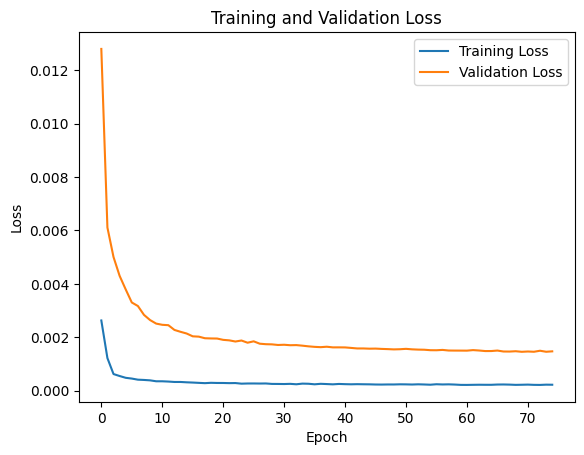

In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 지표 계산
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

# 성능 지표 출력
print("Mean Squared Error (MSE):", test_mse)
print("Mean Absolute Error (MAE):", test_mae)
print("R-squared (R2):", test_r2)# Loss 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [191]:
# 분위수 정규화 복원
restored_train_data = normalized_train_data * len(train_data)
restored_test_data = normalized_test_data * len(test_data)

# 추세 복원을 위한 이동평균 계산
window = 60
rolling_mean_train = pd.Series(restored_train_data).rolling(window=window, min_periods=1).mean()
rolling_mean_test = pd.Series(restored_test_data).rolling(window=window, min_periods=1).mean()

# 추세 복원
detrended_train_data = restored_train_data + rolling_mean_train
detrended_test_data = restored_test_data + rolling_mean_test

# 복원된 데이터로 데이터프레임 생성
restored_df = pd.DataFrame(index=btc_krw_df.index)
restored_df['Actual'] = btc_krw_df['Adj Close']
restored_df['Train Predicted'] = np.nan
restored_df['Test Predicted'] = np.nan
restored_df['Train Predicted'].iloc[sequence_length:sequence_length + len(train_predictions)] = detrended_train_data[sequence_length:]
restored_df['Test Predicted'].iloc[sequence_length:sequence_length + len(test_predictions)] = detrended_test_data[sequence_length:]

# 그래프 시각화
plt.figure(figsize=(12, 6))
plt.plot(restored_df.index, restored_df['Actual'], label='Actual')
plt.plot(restored_df.index, restored_df['Train Predicted'], label='Train Predicted')
plt.plot(restored_df.index, restored_df['Test Predicted'], label='Test Predicted')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.legend()
plt.show()

ValueError: cannot set using a slice indexer with a different length than the value